In [1]:
import pandas as pd
import numpy as np

import joblib
import os

```python
{
    "doc_id": {
        "src": "This is the source text.",
        "ref": "This is the reference translation.",
        "better": {
            "sys_name": "System name 1",
            "sys": "This is system translation 1.",
            "scores": {} 
        },
        "worse": {
            "sys_name": "System name 2",
            "sys": "This is system translation 2.",
            "scores": {}
        }
    }
}
```

In [2]:
def flatten(dataset: dict) -> list:
    flattened = []
    
    for doc_id, doc_data in dataset.items():
        for system in ("better", "worse"):
            data = {
                "src": doc_data["src"],
                "ref": doc_data["ref"],
                "mt": doc_data[system]["sys"],
                "sys_name": doc_data[system]["sys_name"],
                # To facilitate tracing back to the BARTScore paper
                "bartscore_doc_id": doc_id,
            }
            
            flattened.append(data)
    return flattened

In [12]:
LANGUAGE_PAIR = "zh-en"
# LANGUAGE_PAIR = "de-en"

# Step 1. Load and create long-format version of DARR dataset 
filepath = f"./data/machine_translation/{LANGUAGE_PAIR}/data.pkl"
data = joblib.load(filepath)
print(f"Loaded {len(data)} examples for {LANGUAGE_PAIR}.")

# Flatten the nest dict
data = flatten(data)
df_darr = pd.DataFrame(data)

# Remove duplicates
cols = df_darr.columns[:-1]
print(cols)
df_darr = df_darr[~df_darr[cols].duplicated()]
print("Total len of df_darr after removing duplicates:", len(df_darr))

# Step 2. **Load DIRECT ASSESSMENT data**
df_da = pd.read_csv("./data/machine_translation/2019-da.csv")
df_da = df_da[df_da["lp"] == LANGUAGE_PAIR]
print("Total len of df_da:", len(df_da))

# Average duplicate values for DA data
duplicates_cols = ["lp", "src", "mt", "ref"]
# Consider all duplicates (even first and last instances)
duplicates_mask = df_da[duplicates_cols].duplicated(keep=False)
duplicates = df_da[duplicates_mask].copy()
duplicates_annotations = duplicates.groupby(duplicates_cols, as_index=False).count()["annotators"]

duplicates = duplicates.groupby(duplicates_cols, as_index=False).mean()
duplicates["annotators"] = duplicates_annotations

df_da_non_dup = df_da[~duplicates_mask]
df_da = pd.concat((df_da_non_dup, duplicates))
print("Total len of df_da after removing duplicates:", len(df_da))

# Step 3. Merge them based on src, ref, and mt :) using left join to the DF_DARR
df_darr_w_scores = df_darr.merge(df_da, on=["src", "ref", "mt"], how="left")
assert len(df_darr) == len(df_darr_w_scores)
print(len(df_darr_w_scores))
df_darr_w_scores.to_csv(f"./data/machine_translation/{LANGUAGE_PAIR}/data_darr_w_scores.csv")

assert len(df_darr_w_scores) == len(pd.read_csv(f"./data/machine_translation/{LANGUAGE_PAIR}/data_darr_w_scores.csv"))

Loaded 31070 examples for zh-en.
Index(['src', 'ref', 'mt', 'sys_name'], dtype='object')
Total len of df_darr after removing duplicates: 17278
Total len of df_da: 20170
Total len of df_da after removing duplicates: 18687
17278


### Sampling and data formatting

1. scores_raw [0, 100] --> [0, 1]
2. split by context
3. create bins 2 classes and 5 classes



In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

In [23]:
def plot_distributions(data1, data2, label1="", label2="", figsize=(10, 4), **kwargs):
    fig, axes = plt.subplots(1, 2, sharex=True, sharey=True, tight_layout=True, figsize=figsize)

    hist_kwargs = {"bins": 10}
    hist_kwargs.update(**kwargs)
    sns.histplot(ax=axes[0], data=data1, **hist_kwargs)
    sns.histplot(ax=axes[1], data=data2, **hist_kwargs)
    axes[0].set_title(label1)
    axes[1].set_title(label2)
    
def get_distribution(data, binrange, bins):
    out, bins = pd.cut(binrange, bins, retbins=True)
    
    intervals = pd.cut(data, bins=bins)
    return pd.DataFrame(intervals.value_counts() / len(data)).reset_index()


def discretize_dist(data, col, binrange, bins):
    data = data.copy()

    out, bins = pd.cut(binrange, bins=bins, retbins=True) 
    intervals = pd.cut(data[col], bins=bins)
    data["bin"] = intervals
    data["label"] = intervals.cat.codes
    
    return data

In [19]:
from sklearn.model_selection import train_test_split

30150
Using SEED 42
Len(train): 24162 	|	Len(test): 5988
24162 5988
           index  raw_score
0     (0.5, 1.0]   0.852827
1  (-0.001, 0.5]   0.147173
           index  raw_score
0     (0.5, 1.0]   0.859051
1  (-0.001, 0.5]   0.140949
24162 5988


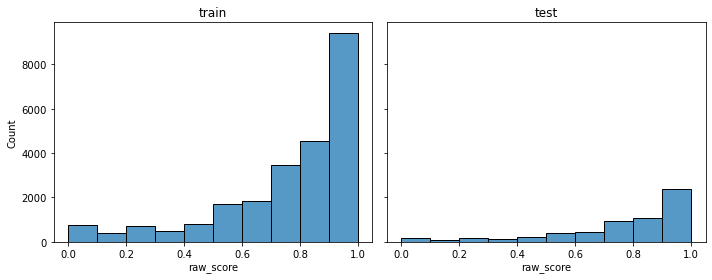

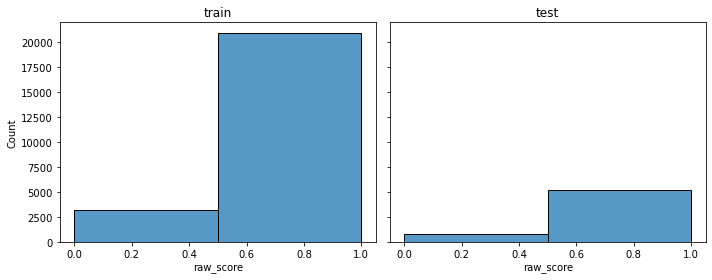

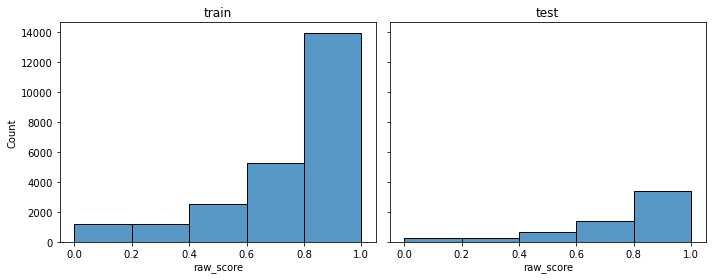

In [28]:
#LANGUAGE_PAIR = "zh-en"
LANGUAGE_PAIR = "de-en"

SEED = 42
# SEED = 4649
#SEED = 91238
TEST_FRACTION = 0.20

RAW_DATASET_DIR = f"./data/machine_translation/{LANGUAGE_PAIR}"
df_darr_w_scores = pd.read_csv(f"{RAW_DATASET_DIR}/data_darr_w_scores.csv")
print(len(df_darr_w_scores))
OUTPUT_DATASET_DIR = f"{RAW_DATASET_DIR}/split_{SEED}"
os.makedirs(OUTPUT_DATASET_DIR, exist_ok=True)

binary_configs = {"binrange": (0, 1), "bins": 2}
fivary_configs = {"binrange": (0, 1), "bins": 5}

print("Using SEED", SEED)

# Scale to [0, 1]
col = "raw_score"
df_darr_w_scores[col] = df_darr_w_scores[col].apply(lambda ex: round(ex/100, 4))
assert df_darr_w_scores[col].apply(lambda ex: 0<=ex<=1).all()

# Train test split (by context)
train_src, test_src = train_test_split(df_darr_w_scores["src"].unique(), test_size=TEST_FRACTION, shuffle=True, random_state=SEED) 
train_df = df_darr_w_scores[df_darr_w_scores["src"].isin(train_src)].reset_index()
test_df = df_darr_w_scores[df_darr_w_scores["src"].isin(test_src)].reset_index()
print("Len(train):", len(train_df), "\t|\tLen(test):", len(test_df))

plot_distributions(train_df[col], test_df[col], "train", "test")
# -----------------------------------------------------------
# Discretize distributions
# -----------------------------------------------------------
# binary
train_bin, test_bin = [discretize_dist(df, col, **binary_configs) for df in (train_df, test_df)]
print(len(train_bin), len(test_bin))
print(get_distribution(train_df[col], **binary_configs))
print(get_distribution(test_df[col], **binary_configs))

train_bin.to_csv(f"{OUTPUT_DATASET_DIR}/2class_train.csv", index=False)
test_bin.to_csv(f"{OUTPUT_DATASET_DIR}/2class_test.csv", index=False)
plot_distributions(train_df[col], test_df[col], "train", "test", **binary_configs)

# 5-ary
train_5ary, test_5ary = [discretize_dist(df, col, **fivary_configs) for df in (train_df, test_df)]
print(len(train_5ary), len(test_5ary))

train_5ary.to_csv(f"{OUTPUT_DATASET_DIR}/5class_train.csv", index=False)
test_5ary.to_csv(f"{OUTPUT_DATASET_DIR}/5class_test.csv", index=False)
plot_distributions(train_df[col], test_df[col], "train", "test", **fivary_configs)

In [26]:
test_bin["label"].value_counts()

1    5104
0     907
Name: label, dtype: int64

In [ ]:
sns.histplot(train_df[col], binrange=(0, 1), bins=10)

In [ ]:
len(df_darr_w_scores[df_darr_w_scores["src"].isin(test_src)])

In [ ]:
len(train_src), len(test_src)

In [ ]:
df_da = pd.read_csv("./data/machine_translation/2019-da.csv")
df_da.groupby(["lp", "src", "ref"]).groupby("mt")